In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

def load_df(path, columns=None, nthreads=4, strings_to_categorical=True):
    try:
        table = pq.read_table(path, columns=columns, nthreads=nthreads)
        return table.to_pandas(strings_to_categorical=strings_to_categorical)
    except Exception as e:
        print(e)
        
def unpack_comb(n):
    return np.unpackbits(np.array([n], dtype=np.uint8))
        
cols= ['device_id', 'service_comb_id', 'time_id', 'timestamp', 'battery_state', 'battery_level', 'screen_on', 'time_diff']
samples_df = load_df(r'C:\Users\ruben\Desktop\Investigation\Version 2\Scripts\src\processed_samples.parquet', cols)
services_df = load_df(r'C:\Users\ruben\Desktop\Investigation\Version 2\Scripts\src\services_dimension.parquet', None)
devices_df = load_df(r'C:\Users\ruben\Desktop\Investigation\Version 2\Scripts\src\devices_dimension.parquet', None)

samples_df['battery_state'] = samples_df.battery_state.replace('full', 'charging')
samples_df.drop(samples_df[samples_df.battery_state == 'not charging'].index, inplace=True)

samples_df.head()

,device_id,service_comb_id,time_id,timestamp,battery_state,battery_level,screen_on,time_diff
0,1,64,1,2017-10-15 18:36:46,discharging,99,1,NaN
1,1,64,1,2017-10-15 18:41:54,discharging,98,1,-308.0
2,1,64,1,2017-10-15 18:46:54,discharging,97,1,-300.0
3,1,64,1,2017-10-15 18:50:35,discharging,96,1,-221.0
4,1,64,1,2017-10-15 18:54:14,discharging,95,1,-219.0


Total devices = 8840
Devices with samples = 2869


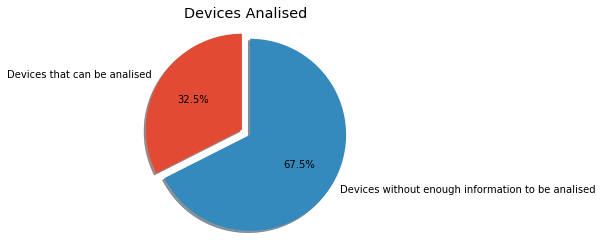

In [2]:
print('Total devices =', len(devices_df))
print('Devices with samples =', len(samples_df.device_id.unique()))

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Devices that can be analised', 'Devices without enough information to be analised'
sizes = [len(samples_df.device_id.unique()), len(devices_df)-len(samples_df.device_id.unique())]
explode = (0.1, 0)

fig1, ax1 = plt.subplots()

plt.title('Devices Analised')
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [3]:
grouped_df = samples_df.drop(['time_id', 'timestamp', 'battery_level'], axis=1).groupby(['device_id', 'service_comb_id', 'battery_state', 'screen_on']).count().dropna().rename(columns={'time_diff': 'number_samples'})
grouped_df['average_per_second'] =  samples_df.drop(['time_id', 'timestamp', 'battery_level'], axis=1).groupby(['device_id', 'service_comb_id', 'battery_state', 'screen_on']).mean().dropna()
grouped_df = grouped_df[grouped_df.number_samples > 2000]
grouped_df['number_samples'] = grouped_df.number_samples.astype(int)
grouped_df['average_per_second'] = grouped_df['average_per_second'].apply(lambda x: round(x, 2))
grouped_df.head(10)

number_samples  \
device_id service_comb_id battery_state screen_on                   
4         78              discharging   0                    4057   
                                        1                    2594   
                          charging      0                    4575   
6         76              discharging   0                    6840   
                                        1                    6616   
                          charging      0                    6015   
          204             discharging   0                    7160   
                                        1                    6355   
                          charging      0                    4671   
12        192             discharging   0                    5109   

                                                   average_per_second  
device_id service_comb_id battery_state screen_on                      
4         78              discharging   0                    -1914.09  
                                        1                     -544.27  
                          charging      0                       88.83  
6         76              discharging   0                     -389.65  
                                        1                     -267.54  
                          charging      0                       69.40  
          204             discharging   0                     -396.54  
                                        1                     -277.67  
                          charging      0                       70.18  
12        192             discharging   0                    -1643.45

# Device Example

In [4]:
devices_ids = list(set(grouped_df.index.get_level_values('device_id')))
print(sorted(devices_ids)[0:20])

[4, 6, 12, 16, 32, 44, 51, 74, 81, 85, 92, 105, 137, 150, 175, 179, 187, 199, 219, 232]


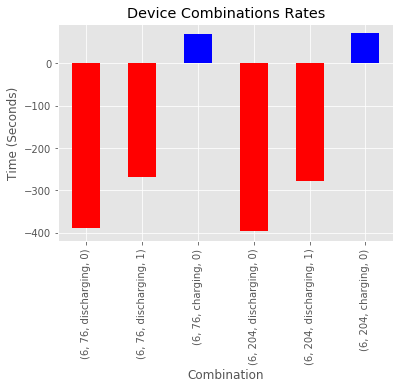

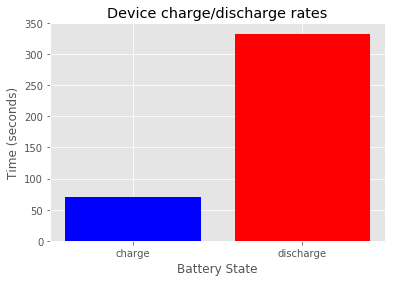

In [5]:
devID = 6
dev_info = grouped_df[grouped_df.index.get_level_values('device_id') == devID]

#plot each device stats
my_colors = ''
for state in dev_info[['average_per_second']].index.get_level_values('battery_state'):
    if state == 'charging':
        my_colors = my_colors + 'b'
    else:
        my_colors = my_colors + 'r'
        
plt1 = dev_info[['average_per_second']].plot(kind='bar', title='Device Combinations Rates', legend=False, color=my_colors)
plt1.set(xlabel='Combination', ylabel='Time (Seconds)')
plt.show()
#-------------
total_average_charge = dev_info[dev_info.index.get_level_values('battery_state') == 'charging'].average_per_second.mean()
total_average_discharge = dev_info[dev_info.index.get_level_values('battery_state') == 'discharging'].average_per_second.mean()

D = {'charge': round(total_average_charge, 2), 'discharge': abs(round(total_average_discharge, 2))}

plt2 = plt.bar(range(len(D)), list(D.values()), align='center', tick_label=list(D.keys()), color='br')
plt.title('Device charge/discharge rates')
plt.xlabel('Battery State')
plt.ylabel('Time (seconds)')

plt.show()

# Services Examples

<h1><center>Charge</center></h1>

In [6]:
services_grouped_df = samples_df.drop(['device_id', 'time_id', 'timestamp', 'battery_level'], axis=1).groupby(['service_comb_id', 'battery_state', 'screen_on']).count().dropna().rename(columns={'time_diff': 'number_samples'})
services_grouped_df['average_per_second'] =  samples_df.drop(['device_id', 'time_id', 'timestamp', 'battery_level'], axis=1).groupby(['service_comb_id', 'battery_state', 'screen_on']).mean().dropna()
services_grouped_df['std'] =  samples_df.drop(['device_id', 'time_id', 'timestamp', 'battery_level'], axis=1).groupby(['service_comb_id', 'battery_state', 'screen_on']).std().dropna()
services_grouped_df['number_devices'] =  samples_df.drop_duplicates(['service_comb_id','battery_state','screen_on','device_id']).drop(['time_id', 'timestamp', 'battery_level'], axis=1).groupby(['service_comb_id', 'battery_state', 'screen_on']).count().dropna().device_id
services_grouped_df = services_grouped_df[services_grouped_df.number_samples > 2000]
services_grouped_df['number_samples'] = services_grouped_df.number_samples.astype(int)
services_grouped_df['average_per_second'] = services_grouped_df['average_per_second'].apply(lambda x: round(x, 2))
services_grouped_df.head(10)

number_samples  average_per_second  \
service_comb_id battery_state screen_on                                       
0               discharging   0                   83947            -1526.10   
                              1                  146758             -575.69   
                charging      0                  363420              100.67   
                              1                   66860              147.45   
2               discharging   0                   10045            -1235.41   
                              1                   24261             -395.69   
                charging      0                   28127               96.50   
                              1                    7751              114.19   
4               discharging   0                   76202            -1181.31   
                              1                  134922             -554.86   

                                                  std  number_devices  
service_comb_id battery_state screen_on                                
0               discharging   0           6212.201172           504.0  
                              1          11131.944336           609.0  
                charging      0            397.986389           604.0  
                              1           9776.275391           658.0  
2               discharging   0           2850.859863            44.0  
                              1           2100.445557            50.0  
                charging      0            267.126251            52.0  
                              1           2918.891602            56.0  
4               discharging   0           3011.713867           445.0  
                              1          16343.435547           546.0

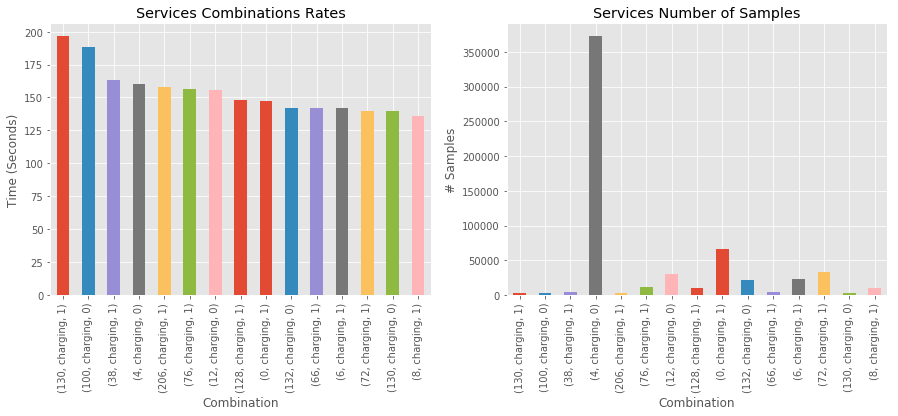

In [7]:
top_services_charge = services_grouped_df[services_grouped_df.average_per_second > 0].sort_values(by='average_per_second', ascending=False)[0:15]

plt.subplots(1,2,figsize=(15, 5))

plt.subplot(1, 2, 1)
plot1 = top_services_charge.average_per_second.plot(kind='bar', title='Services Combinations Rates', legend=False)
plot1.set(xlabel='Combination', ylabel='Time (Seconds)')

plt.subplot(1, 2, 2)
plot2 = top_services_charge.number_samples.plot(kind='bar', title='Services Number of Samples', legend=False)
plot2.set(xlabel='Combination', ylabel='# Samples')

plt.show()

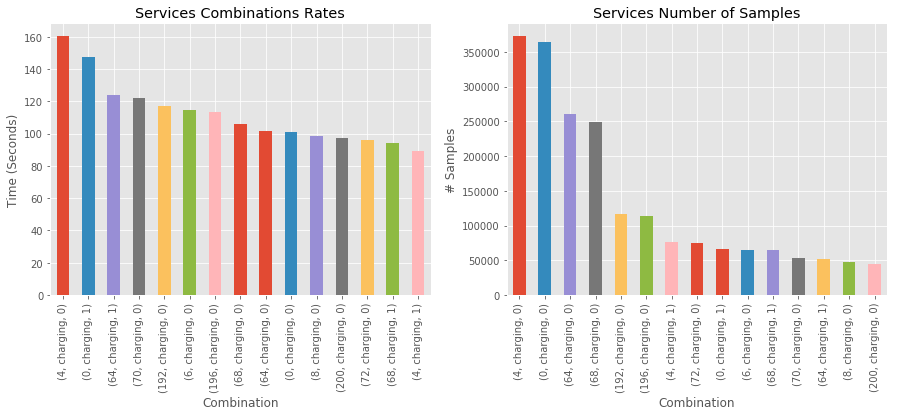

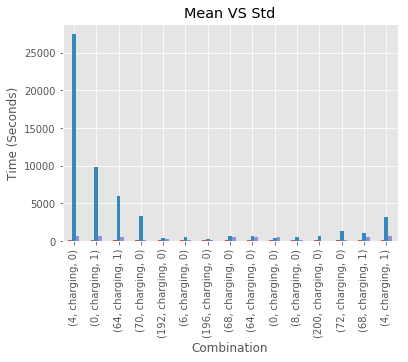

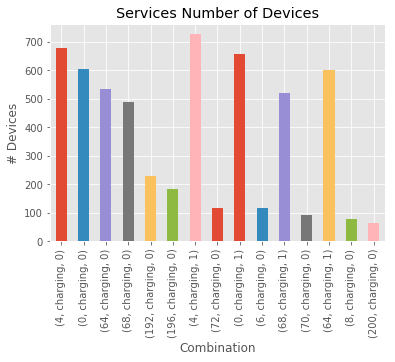

,bluetooth_enabled,location_enabled,power_saver_enabled,flashlight_enabled,nfc_enabled,unknown_sources,developer_mode
0,0,0,0,0,0,0,0
64,0,1,0,0,0,0,0
192,1,1,0,0,0,0,0
4,0,0,0,0,0,1,0
68,0,1,0,0,0,1,0
196,1,1,0,0,0,1,0
6,0,0,0,0,0,1,1
72,0,1,0,0,1,0,0
70,0,1,0,0,0,1,1
8,0,0,0,0,1,0,0


In [24]:
top_services_charge = services_grouped_df[services_grouped_df.average_per_second > 0].sort_values(by='number_samples', ascending=False)[0:15]

plt.subplots(1,2,figsize=(15, 5))

plt.subplot(1, 2, 1)
plot1 = top_services_charge.average_per_second.sort_values(ascending=False).plot(kind='bar', title='Services Combinations Rates', legend=False)
plot1.set(xlabel='Combination', ylabel='Time (Seconds)')

plt.subplot(1, 2, 2)
plot2 = top_services_charge.number_samples.plot(kind='bar', title='Services Number of Samples', legend=False)
plot2.set(xlabel='Combination', ylabel='# Samples')

#--------------------------
plot3 = top_services_charge.sort_values(by='average_per_second', ascending=False).drop('number_samples', axis=1).plot(kind='bar', legend=False, title='Mean VS Std')
plot3.set(xlabel='Combination', ylabel='Time (Seconds)')

plt.show()
#------
plot4 = top_services_charge.number_devices.plot(kind='bar', title='Services Number of Devices', legend=False)
plot4.set(xlabel='Combination', ylabel='# Devices')
plt.show()

matrix = []
for comb_id in set(top_services_charge.index.get_level_values('service_comb_id')):
    matrix.append(list(unpack_comb(comb_id))) 
matrix = np.matrix(matrix)
matrix = np.delete(matrix, 7, 1)

t = pd.DataFrame(matrix, columns=list(services_df.columns)[1:], index=set(top_services_charge.index.get_level_values('service_comb_id')))
t.loc['sum'] = t.sum()
display(t)

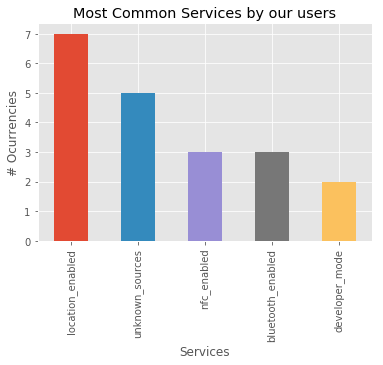

In [9]:
total = t.loc['sum']
total = total[total > 0].sort_values(ascending=False)

plot = total.plot(kind='bar', title='Most Common Services by our users')
plot.set(xlabel='Services', ylabel='# Ocurrencies')
plot

<h1><center>Discharge</center></h1>

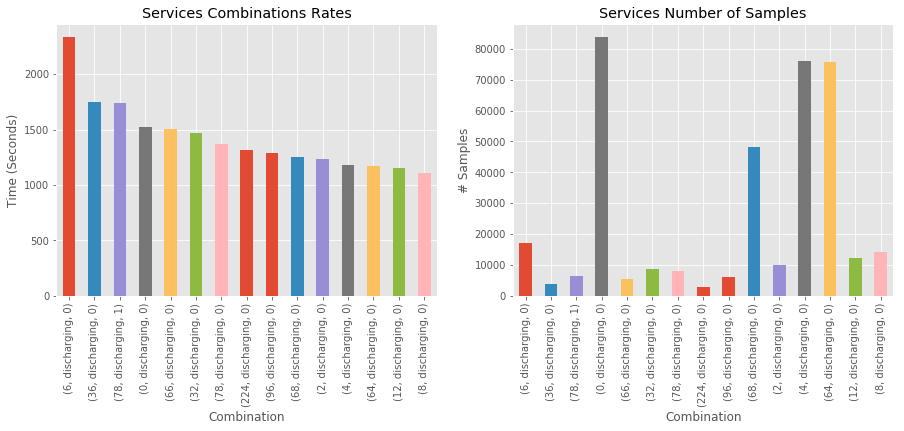

In [10]:
top_services_discharge = services_grouped_df[services_grouped_df.average_per_second < 0].sort_values(by='average_per_second')[0:15]
top_services_discharge['average_per_second'] = abs(top_services_discharge['average_per_second'])

plt.subplots(1,2,figsize=(15, 5))

plt.subplot(1, 2, 1)
plot1 = top_services_discharge.average_per_second.plot(kind='bar', title='Services Combinations Rates', legend=False)
plot1.set(xlabel='Combination', ylabel='Time (Seconds)')

plt.subplot(1, 2, 2)
plot2 = top_services_discharge.number_samples.plot(kind='bar', title='Services Number of Samples', legend=False)
plot2.set(xlabel='Combination', ylabel='# Samples')

plt.show()

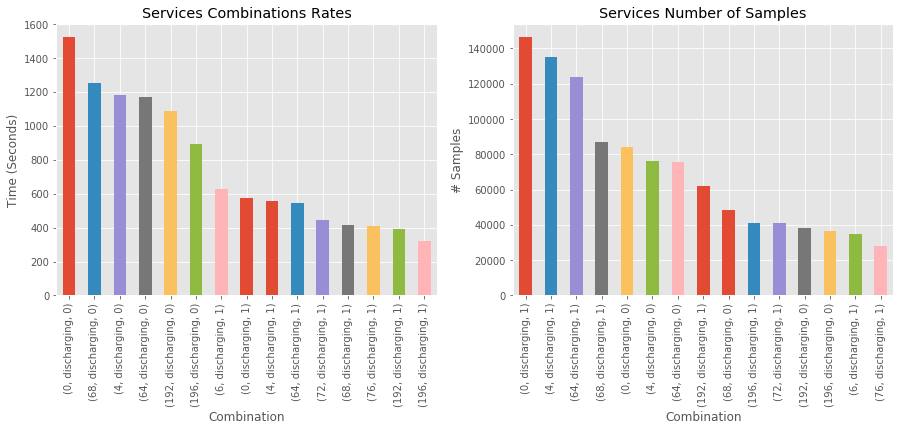

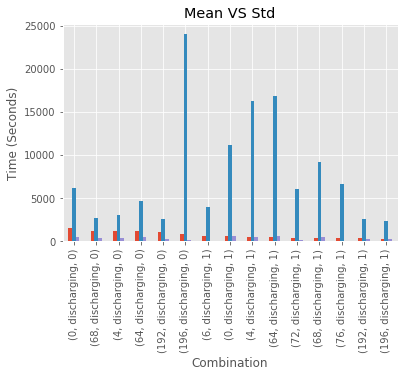

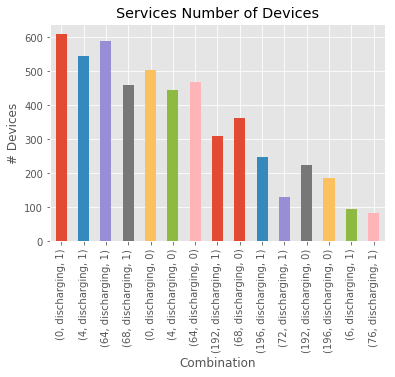

,bluetooth_enabled,location_enabled,power_saver_enabled,flashlight_enabled,nfc_enabled,unknown_sources,developer_mode
0,0,0,0,0,0,0,0
64,0,1,0,0,0,0,0
192,1,1,0,0,0,0,0
4,0,0,0,0,0,1,0
68,0,1,0,0,0,1,0
196,1,1,0,0,0,1,0
6,0,0,0,0,0,1,1
72,0,1,0,0,1,0,0
76,0,1,0,0,1,1,0
sum,2,6,0,0,2,5,1


In [25]:
top_services_discharge = services_grouped_df[services_grouped_df.average_per_second < 0].sort_values(by='number_samples', ascending=False)[0:15]
top_services_discharge['average_per_second'] = abs(top_services_discharge['average_per_second'])

plt.subplots(1,2,figsize=(15, 5))

plt.subplot(1, 2, 1)
plot1 = top_services_discharge.average_per_second.sort_values(ascending=False).plot(kind='bar', title='Services Combinations Rates', legend=False)
plot1.set(xlabel='Combination', ylabel='Time (Seconds)')

plt.subplot(1, 2, 2)
plot2 = top_services_discharge.number_samples.plot(kind='bar', title='Services Number of Samples', legend=False)
plot2.set(xlabel='Combination', ylabel='# Samples')


#--------------------------
plot3 = top_services_discharge.sort_values(by='average_per_second', ascending=False).drop('number_samples', axis=1).plot(kind='bar', legend=False, title='Mean VS Std')
plot3.set(xlabel='Combination', ylabel='Time (Seconds)')
plt.show()
#------

plot4 = top_services_discharge.number_devices.plot(kind='bar', title='Services Number of Devices', legend=False)
plot4.set(xlabel='Combination', ylabel='# Devices')
plt.show()

matrix = []
for comb_id in set(top_services_discharge.index.get_level_values('service_comb_id')):
    matrix.append(list(unpack_comb(comb_id))) 
matrix = np.matrix(matrix)
matrix = np.delete(matrix, 7, 1)

t = pd.DataFrame(matrix, columns=list(services_df.columns)[1:], index=set(top_services_discharge.index.get_level_values('service_comb_id')))
t.loc['sum'] = t.sum()
display(t)

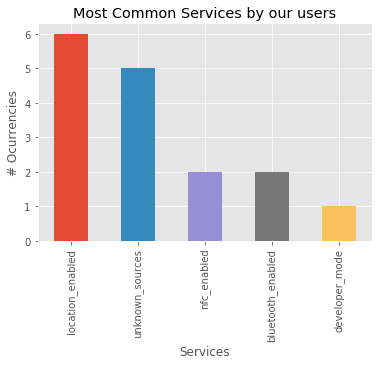

In [12]:
total = t.loc['sum']
total = total[total > 0].sort_values(ascending=False)

plot = total.plot(kind='bar', title='Most Common Services by our users')
plot.set(xlabel='Services', ylabel='# Ocurrencies')
plot